Considere the following ordinary differential equation:
$$(1)\quad \forall x\in [0,1]\quad g'(x)+g(x)=0 \quad g(0)=1.$$
One can show that the solution of this equation is unic and given by
$$\phi: x\mapsto e^{-x}.$$

The goal of this short notebook is to compare euler method and different architectures of neuronal networks that are able to "solve" this equation.

Euler method:

But first let's start with one of the classical numerical method, the Euler method.
The idea behind this method is to say that, since for $x\in C^1$
$$x^{\prime}(t):=\lim_{h\to 0}\frac{x(t+h)-x(t)}{h},$$ then one can approximate
$x^{\prime}(t)$ by $\frac{x(t+h)-x(t)}{h}$ for $h$ sufficiently small.
Now if one want to solve $$\forall t\in [0,1]\quad x^{\prime}(t)=F(x(t),t),\quad x(0)=1,$$ one use the previous approximation to find
$$x(t+h)\approx x(t)+hF(x(t),t).$$
So, given a function $F$, $(t_1,t_2,...,t_N)$ a subdivision of $[0,1]$ and $h>0$, we have
$$\forall k\in [1,N]\quad x(t_{k}+h)=x(t_k)+hF(x(t_k),t_k).$$

In our case:
$$F : x\mapsto -x, \forall k\in [0,1000]\quad t_k=\frac{k}{N}\quad h=1/1000.$$



Let's code it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

In [2]:
def true_sol(t):
  """

  Args:
    t: time

  Returns: exp(-t) solution of the equation (1)

  """
  return np.exp(-t)
def euler(N=10000):
  """

  Args:
    N: number of subdivision of the [0,1] interval

  Returns: list of (approx(t) for t in subdivision) where approx(t) is the approximation of the true solution

  """
  h=1/N
  x=np.zeros(N)
  x[0]=1 #initial condition
  for k in range(N-1):
    x[k+1]=x[k]-h*x[k]
  return x

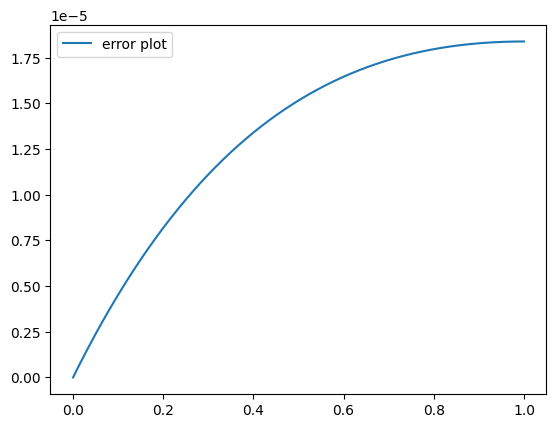

In [3]:
plt.figure()
subdivision=[k/10000 for k in range(10000)]
#plt.plot(subdivision, euler())
#plt.plot(subdivision, [true_sol(t) for t in subdivision])
plt.plot(subdivision, np.abs(np.array([true_sol(t) for t in subdivision])-np.array(euler())), label='error plot')
plt.legend()
plt.show()

Now the idea is to find a neuronal network that approximate the solution of $(1)$.

We are looking for parameters $\Theta=(\theta_1,\theta_2)$ and $\beta=(b_1,b_2)$ such that if
$$g_{\Theta,β}(t):=f_{1}(f_{2}(\theta_1 t+b_1) \theta_2+b_2)$$ where $f_1$ and $f_2$ are two given activations functions, one has
$$g_{\Theta,β}^{\prime}+g_{\Theta,β}\approx 0 \quad g_{\Theta,β}(0)\approx 1.$$

Existence?

To do so, one define the loss
$$L_{\lambda}(\Theta,\beta):=\frac{1}{N}\sum_{1\leq i\leq N}(g_{\Theta,β}^{\prime}(x_i)+g_{\Theta,β}(x_i))^2+\lambda (g_{\Theta,β}(0)-1)^2.$$
Where $$\forall i\in [1,N]\quad x_i:=\frac{i}{N}.$$

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [163]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.fc1 = nn.Linear(1, 200) #(input_size, hidden_size)
    self.fc2 = nn.Linear(200, 1) #(input_size, hidden_size)

  def forward(self, t):
    x = torch.sigmoid(self.fc1(t))
    return self.fc2(x)

*Some explications: *

Here the input size is equal to $1$ since the unknown of the ODE is a function $g: \mathbb{R}^{\text{input_size}}\to \mathbb{R}^{\text{output_size}}.$

$fc1$ corresponds the first layer of width $hidden_size=100$ which acts as a linear transformation Ax+b with $A\in \mathbb{R}^{\text{input_size}^{2}}$ and $b\in \mathbb{R}^{\text{input_size}}$.

Same thing for $fc2$

We apply, on the first layer, the sigmoid function defined as
$$\sigma : x\mapsto \frac{1}{1+e^{-x}}.$$

In [164]:
class Resnet(nn.Module):
  def __init__(self):
    super(Resnet,self).__init__()
    self.fc1 = nn.Linear(1, 10)
    self.fc2 = nn.Linear(10, 1)

  def forward(self, t):
    x = torch.sigmoid(self.fc1(t))
    return self.fc2(x)+t

In [165]:
def loss_fn(model,t):
  t.requires_grad_(True)
  x=model(t)
  x_prime = torch.autograd.grad(outputs=x, inputs=t,
                                   grad_outputs=torch.ones_like(x),
                                   create_graph=True)[0]
  loss1 = (x_prime + x) ** 2
  loss2 = (model(torch.tensor([[0.0]])) - 1) ** 2

  return torch.mean(loss1) + loss2


Here we have coded:
$$L_{1}(\Theta,\beta):=\frac{1}{N}\sum_{1\leq i\leq N}(g_{\Theta,β}^{\prime}(x_i)+g_{\Theta,β}(x_i))^2+ (g_{\Theta,β}(0)-1)^2.$$
Where $$\forall i\in [1,N]\quad x_i:=\frac{i}{N}.$$

In [184]:
def train(model):
  loss_values=[]
  optimizer = optim.Adam(model.parameters(), lr=0.1)
  for epoch in range(10000):
    optimizer.zero_grad()
    t = torch.linspace(0, 1, 100).view(-1, 1) #Training is on [0,1]
    loss = loss_fn(model, t)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        #print(f'Époch {epoch}: Loss = {loss.item()}')
        loss_values.append(loss.item())

In [185]:
"for each f=MLP or Resnet we store x_VALUES containes f(t) for t in range [0,10]"
x_VALUES=[]
t_values = torch.linspace(0, 20, 500).view(-1, 1)
MODELS=[MLP(),Resnet()]
for model in MODELS:
  train(model)
  x_values = model(t_values).detach().numpy()
  x_VALUES.append(x_values)

In [186]:
#for model in MODELS:
#  print(f"\n Optimal weights {model}:")
#  for name, param in model.named_parameters():
#    print(f"{name}: {param.data.numpy()}")

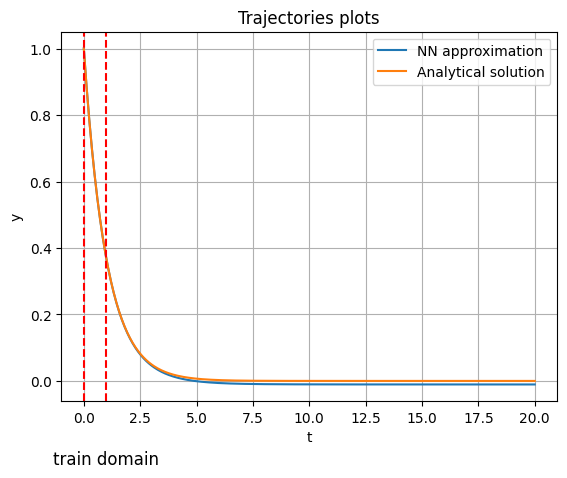

In [187]:
# graphical check of the validity of the solution
t_values = torch.linspace(0, 20, 500).view(-1, 1)
x_values = x_VALUES[0]

# plot section
plt.plot(t_values.numpy(), x_values, label=f'NN approximation')
plt.plot(t_values.numpy(), [true_sol(t) for t in t_values.numpy()], label='Analytical solution')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Trajectories plots')

plt.axvline(x=0, color='red', linestyle='--')  # Ligne verticale rouge à x=0
plt.axvline(x=1, color='red', linestyle='--')  # Ligne verticale rouge à x=1
plt.text(1, -0.25, 'train domain', horizontalalignment='center', fontsize=12)


plt.legend()
plt.grid()
plt.show()

We can see that both MLP and Resnet(MLP) architectures are able to approximate the true solution on the train domain. However they aren't able to generalize well as we can see on the above plot.

Assume $f$ is the analitical solution and $\phi$ is the neuronal network that we trained on $[0,T]$.

For any $ɛ>0$ we define $$T_ɛ(\phi):=\sup\left\{t\geq T: \quad  \left|\phi-f \right|<ɛ \right\}.$$

We can see that $$\forall \varepsilon>0\quad T_{ɛ}(MLP)>T_{ɛ}(Resnet).$$

In [193]:
#saving "best weights"
torch.save(MODELS[0].state_dict(), 'model_weights.pth')

In [170]:
#store the values of each neuronal network
values_MLP=x_VALUES[0]
values_Resnet=x_VALUES[1]


def difference(f,g):
  return np.abs(f-g)

f=[true_sol(t) for t in t_values.numpy()] #Analytical solution
diff=difference(f,values_Resnet)
Epsilon=[1/(k+1) for k in [1,10,100,1000,10000]] #epsilon value in the formula above

time=t_values.numpy()
diff_resnet=difference(f,values_Resnet)
diff_MLP=difference(f,values_MLP)
T_MLP=[]
T_resnet=[]
for eps in Epsilon:
  index_resnet=np.where(diff_resnet<eps)[0]
  index_mlp=np.where(diff_MLP<eps)[0]
  time_mlp=time[np.max(index_mlp)][0] #T_epsilon(MLP)
  time_resnet=time[np.max(index_resnet)][0] #T_epsilon(Resnet)
  T_MLP.append(time_mlp) #Store the values
  T_resnet.append(time_resnet) #Store the values



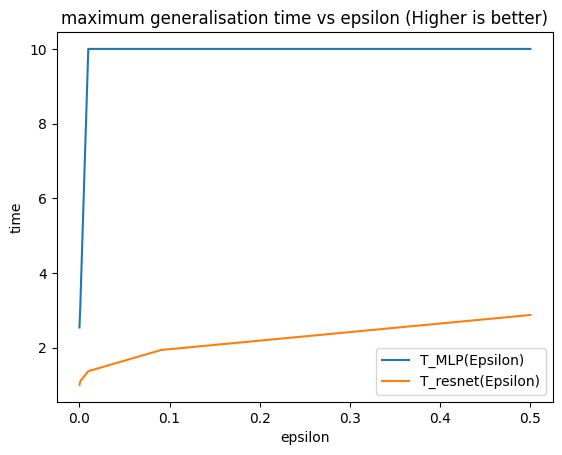

In [171]:
#Plot
plt.figure()
plt.plot(Epsilon, T_MLP, label='T_MLP(Epsilon)')
plt.plot( Epsilon,T_resnet, label='T_resnet(Epsilon)')
plt.title('maximum generalisation time vs epsilon (Higher is better)')
plt.xlabel("epsilon")
plt.ylabel("time")
plt.legend()
plt.show()